Κακή Υλοποίηση ενός κακού μοντέλου. Αλλά νομίζω πως λειτουργεί:

Ορίζω ως:

$N$ Το σύνολο των χωρών που συμμετέχουν και $i$ η κάθε χώρα που συμμετέχει στο ETS. Η Σλοβακία έμεινε εκτός γιατί δεν έχω όλα τα data. 

$A$ το συνολικό allocation free αδειών για αυτή τη χρονιά.

$A_i$ το ζητούμενο allocation της κάθε χώρας.

$slope_i$ την κλίση της γραμμικής παλινδρόμησης μεταξύ GDP και BAU emissions.

$free_i$ free allocation of last year of country i  

$free_{x,i}$ free allocation of last year of country i of year x

$GDP{x,i}$ GDP per capita of country i of year x

$\overline{GDP_x}$ average GDP of year x

$pop_i$ population of country i  

$Utility_i = slope_i \times A_i$


Προσπαθούμε να λύσουμε το παρακάτω πρόβλημα γραμμικού προγραμματισμού:

$ maximaze(\sum_{ i \in N}{Utilities_i})$

c.t.
$A_i \leq 1.5 \times free_i$

$A_i \geq   free_i \times 0.5$

$\sum_{i \in N}{A_i} = A$ 


Ο υπολογισμός του w4 τελικά ήταν εντελώς λάθος και δεν χρησιμοποιήθηκε γιατί δεν ήταν καν συνεπείς οι περιορισμοί για τον simplex.

Αλλα για την ιστορία:
$K_i = (GDP_{x,i}- \overline{GDP_x)} - (GDP_{x-1,i}- \overline{GDP_{x-1}})$

$w4_i = \frac{\frac{pop_i}{max(pop_j)} - \frac{K_i}{max(K_j)}}{4} + 1, \forall j \in N $




In [4]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install mysql.connector

In [5]:
import mysql.connector
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import math
from scipy import stats
from scipy.optimize import linprog
import pandas as pd


In [6]:
#  DEFINITIONS

# DATABSE
db='eu_ets'
use='root'
passwor=''
hos='localhost'

# Diagrams of data
Need_diagrams_of_random_data = False
Countrys_number_for_diagrams = 10 # Διάλεξε χώρα
# 0 Austria, 1 Belgium, 2 Bulgaria, 3 Croatia, 4 Cyprus, 5 Czech Republic, 6 Denmark, 7 Estonia, 8 Finland, 9 France, 10 Germany, 11 Greece, 12 Hungary, 13 Ireland, 14 Italy, 15 Latvia, 16 Lithuania, 17 Luxembourg, 18 Malta, 19 Netherlands, 20 Poland, 21 Portugal, 22 Romania, 23 Slovenia, 24 Spain, 25 Sweden, 26 United Kingdom


# Training of the linear regration of GDP over CO2 emissions
# Data available from 1960 to 2020
first_year_of_calculation = 1990
last_year_of_calculation = 2018
Need_diagrams_of_linear_regration = False # True if you want to see the diagrams of the linear regression

Prediction_year = 2018 # must be between 


In [7]:
def year(x):
    return x - 1960

In [8]:

cnx = mysql.connector.connect(user=use, password=passwor,
                                  host=hos,
                                  database=db)
qurry_countries = "SELECT name, abbr2L, eu_abbr2L from countries where EU =1"
VerifiedEmissionsByYear= [[[0 for x in range(3)] for x in range(23)] for x in range(28)]

curs = cnx.cursor()
curs.execute(qurry_countries)
myresult = curs.fetchall()
countries_to_abbr = {}
countries_to_full = {}
countries_num_to_abbr = {}
countries_to_eu_2Labbr = {} # El for GR, UK for GB etc.
for key, x in enumerate(myresult):
     countries_to_abbr[str(x[0])]=str(x[1])
     countries_to_eu_2Labbr[str(x[0])]=str(x[2])
     countries_to_full[str(x[1])]= str(x[0])
     countries_num_to_abbr[key] = str(x[1])
# print(countries_to_abbr, countries_to_full, countries_num_to_abbr)
countries_without_slovakia=  countries_to_abbr.copy() 
countries_without_slovakia.pop('Slovakia')
countries_without_slovakia = list(countries_without_slovakia.keys())
# print(countries_without_slovakia)
EUcountries = countries_without_slovakia
EUcountries.sort()
print(countries_to_abbr.keys())
print(countries_to_abbr, countries_without_slovakia)


dict_keys(['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Estonia', 'Greece', 'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia', 'United Kingdom'])
{'Austria': 'AT', 'Belgium': 'BE', 'Bulgaria': 'BG', 'Cyprus': 'CY', 'Czech Republic': 'CZ', 'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Greece': 'GR', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR', 'Croatia': 'HR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Latvia': 'LV', 'Malta': 'MT', 'Netherlands': 'NL', 'Poland': 'PL', 'Portugal': 'PT', 'Romania': 'RO', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'GB'} ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Lat

In [9]:
Population = {}
with open('API_SP.POP.TOTL_DS2_en_csv_v2_3731322.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    # print(EUcountries)
    for row in spamreader:
       
        if len(row) > 0 and row[0] in json.dumps(EUcountries):  
            k=[]
            for i in range (1960,2021):
                k.append(int(json.loads(row[5+year(i)])))
            #print (countries_to_abbr[json.loads(row[0])])
            Population[json.loads(row[0])]=k
# print (Population[EUcountries[5]][-1:])


In [10]:
def zero_if_none(x):
    if x == None or x =="":
        return 0
    elif not x.isnumeric():
        buff= x.split('.')
        a = int(buff[0])
        b = int(buff[1])
        c = a + float("0."+buff[1])
        return c
    else:
        return float(x)


In [11]:
def Normalize_dictionary(x):
    test = {}
    max = 0
    for i in x.values():
        if abs(i) > max:
            max = abs(i)
    for key, value in x.items():
        test[key] = -value/max  #Lingprog expects a minimize problem
    return test


In [12]:
CO2_BAU_emissions = {}
with open('API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3830791.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
       
        if len(row) > 0 and row[0] in json.dumps(EUcountries):  
            k=[]
            for i in range (1960,2021):
                k.append(int(math.floor(float(zero_if_none(json.loads(row[4+year(i)])))))*1000)
            CO2_BAU_emissions[json.loads(row[0])]=k

In [13]:
# Ektiposi random dedomenon gia elegxo

# print('Διάλεξε χώρα')
# for key, x in enumerate(EUcountries):
#     print(str(key)+ " " + x, end=", ")
# val = int(input("Νούμερο: "))
# x = np.array(range(1960,2021))
# z = CO2_BAU_emissions[EUcountries[val]]
# y = np.array(z)
# fig, ax = plt.subplots()
# ax.set_title("BAU Emissions By Year of " + EUcountries[val])
# ax.plot(x, y)

In [14]:
curs = cnx.cursor()

## Υπολογισμός Verified Emissions για κάθε χώρα και 
for index in range(len(EUcountries)):
    for i in range(23):
        querr = "SELECT SUM(verified) FROM `eutl_compliance` WHERE country = '" + str(countries_to_abbr[EUcountries[i]]) +"' AND etos ='" + str(i+2000) +"'"
        VerifiedEmissionsByYear[index][i][0] = EUcountries[index]
        VerifiedEmissionsByYear[index][i][1] = index

        curs.execute(querr)
        myresult = curs.fetchall()
        if myresult[0][0] is None :
            VerifiedEmissionsByYear[index][i][2] = 0
        else:
            VerifiedEmissionsByYear[index][i][2] = int(myresult[0][0])

for i in range(len(EUcountries)):
    for j in range(23):
        if VerifiedEmissionsByYear[i][j][2] == 0:
            VerifiedEmissionsByYear[i][j][2] = -1

In [15]:
if (Need_diagrams_of_random_data):
    x = np.array(range(first_year_of_calculation,last_year_of_calculation+1))
    print(VerifiedEmissionsByYear[Countrys_number_for_diagrams][0][1])
    y = Population[EUcountries[Countrys_number_for_diagrams]]
    fig, ax = plt.subplots()
    ax.set_title("Population By Year of " + EUcountries[Countrys_number_for_diagrams])
    ax.plot(x, y)

In [16]:
if (Need_diagrams_of_random_data):
    x = np.array(range(2005,2019))
    z=[]
    for i in range(23):
        z.append(VerifiedEmissionsByYear[Countrys_number_for_diagrams][i][2])
        print(VerifiedEmissionsByYear[Countrys_number_for_diagrams][i][2], end= ", ")
    print(z[5:19])
    y = np.array(z[5:19]) # pare mono ta kommatia 
    fig, ax = plt.subplots()
    ax.set_title("Verified Emissions By Year of " + EUcountries[Countrys_number_for_diagrams])
    ax.plot(x, y)

In [17]:
#GDP Read
GDP = {}
with open('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3840536.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        if len(row) > 0 and row[0] in json.dumps(EUcountries):  
            k=[]
            for i in range (1960,2021):
                k.append(int(math.floor(float(zero_if_none(json.loads(row[4+year(i)])))))*1000)
            GDP[json.loads(row[0])]=k
# for x in GDP:
#     print (x, len(GDP[x]))

# GDP sort by key

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'Austria': -0.38637328897461415, 'Belgium': 0.7102109414205193, 'Bulgaria': 0.09538908064092859, 'Croatia': -0.10917131050634753, 'Cyprus': -0.3742034557912413, 'Czech Republic': 0.3144170781861374, 'Denmark': 0.3709606512971465, 'Estonia': -0.15371935195966452, 'Finland': 0.1934893788520517, 'France': 1.0, 'Germany': 0.625841160321778, 'Greece': -0.13895075724576486, 'Hungary': 0.34586535132459983, 'Ireland': -0.4630624181872827, 'Italy': 0.15504031799321194, 'Latvia': 0.2939738677576469, 'Lithuania': 0.33392845642405816, 'Luxembourg': -0.03242545353922863, 'Malta': 0.2837034746679417, 'Netherlands': 0.15981759299537068, 'Poland': 0.31185756372439705, 'Portugal': -0.08175822778221652, 'Romania': 0.14199120640677512, 'Slovenia': 0.030192411153583426, 'Spain': -0.24904909644659318, 'Sweden': 0.9658088845229976, 'United Kingdom': 0.4809173511389139}


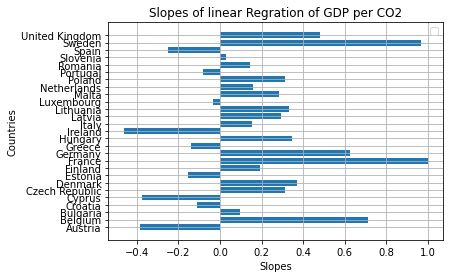

In [18]:
# παμε για παλινδρόμηση από πακέτο ...
slopes = {}
results_of_linear = {}
for c in EUcountries:

    xx = CO2_BAU_emissions[c].copy()
    yy = GDP[c].copy()

    # Keep only the selected years of training data
    xx = xx[first_year_of_calculation-1960:last_year_of_calculation-1960+1]
    yy = yy[first_year_of_calculation-1960:last_year_of_calculation-1960+1]
    # clean 0 values from the lists
    start = first_year_of_calculation
    end = last_year_of_calculation
    while xx[0] == 0 or yy[0] == 0 or xx[0] == -1 or yy[0] == -1:
        xx = xx[1:]
        yy = yy[1:]
        start += 1
    while xx[-1] == 0 or yy[-1] == 0 or xx[-1] == -1 or yy[-1] == -1:
        xx = xx[:-1]
        yy = yy[:-1]
        end -= 1

    results_of_linear[c] = stats.linregress(xx, yy)
    
    slopes[c] = float(results_of_linear[c].slope)
    if (Need_diagrams_of_linear_regration):
        print (results_of_linear[c])
        plt.plot(xx, yy, 'o' )
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = results_of_linear[c].intercept + results_of_linear[c].slope * x_vals
        plt.plot(x_vals, y_vals)
        plt.legend()
        plt.grid()
        plt.title('Linear Regression of CO2 emissions and GDP for ' + c + ' in ' + str(start) + '-' + str(end)+ "\n" + "R^2 = " + str(results_of_linear[c].rvalue**2))
        plt.ylabel('GDP')
        plt.xlabel('CO2 emissions')
        plt.show()
slopes = Normalize_dictionary(slopes)
print(slopes)


# graph for slopes
plt.barh(list(slopes.keys()) ,list(slopes.values()))
plt.ylabel('Countries')
plt.xlabel('Slopes')
plt.title('Slopes of linear Regration of GDP per CO2')
plt.grid()
plt.legend()
plt.show()


In [21]:
def lin_reg(start,end):
    res_of_linear = {}
    slo ={}
    for c in EUcountries:

        xx = CO2_BAU_emissions[c].copy()
        yy = GDP[c].copy()

        # Keep only the selected years of training data
        xx = xx[start-1960:end-1960+1]
        yy = yy[start-1960:end-1960+1]
        # clean 0 values from the lists
        while xx[0] == 0 or yy[0] == 0 or xx[0] == -1 or yy[0] == -1:
            xx = xx[1:]
            yy = yy[1:]
        while xx[-1] == 0 or yy[-1] == 0 or xx[-1] == -1 or yy[-1] == -1:
            xx = xx[:-1]
            yy = yy[:-1]

        res_of_linear[c] = stats.linregress(xx, yy)
        xx = CO2_BAU_emissions[c].copy()
        yy = GDP[c].copy()
        xx = xx[start-1960:end-1960+1]
        yy = yy[start-1960:end-1960+1]
        # clean 0 values from the lists
        while xx[0] == 0 or yy[0] == 0 or xx[0] == -1 or yy[0] == -1:
            xx = xx[1:]
            yy = yy[1:]
        while xx[-1] == 0 or yy[-1] == 0 or xx[-1] == -1 or yy[-1] == -1:
            xx = xx[:-1]
            yy = yy[:-1]
        res_of_linear[c] = stats.linregress(xx, yy)
        slo[c] = float(res_of_linear[c].slope)
    slo = Normalize_dictionary(slo)
    return slo

    

In [42]:
def create_table_of_slopes_for_differnt_periods_for_latex():
    res_1990_1995 = lin_reg(1990,1995)
    res_1996_2000 = lin_reg(1996,2000)
    res_2001_2005 = lin_reg(2001,2005)
    res_2006_2010 = lin_reg(2006,2010)
    res_2011_2018 = lin_reg(2011,2018)
    stds = []
    for i in EUcountries:
        stds.append(np.std([res_1990_1995[i],res_1996_2000[i],res_2001_2005[i],res_2006_2010[i],res_2011_2018[i]]))

    dic = {"Countries" : slopes.keys(), "1990-2018" : slopes.values(),"1990-1995":res_1990_1995.values(),"1996-2000": res_1996_2000.values(), "2001-2005" : res_2001_2005.values(), "2006-2010" : res_2006_2010.values(), "2011-2018": res_2011_2018.values(), "STD": stds}

    df = pd.DataFrame(dic)
    # print(df)
    return df.to_latex()
# create_table_of_slopes_for_differnt_periods_for_latex()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


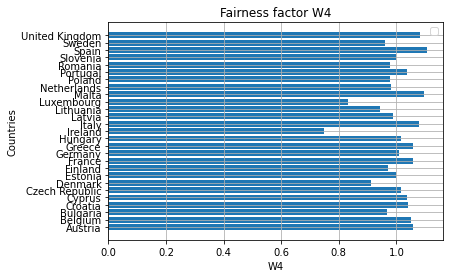

In [43]:
# STUPID DATA CALCULATION

#Max Popoulation
Population_max_per_year = [0 for i in range (1960,2021)]
Population_max_per_year_country = ['' for i in range (1960,2021)]
for x in EUcountries:
    if x == 'Slovakia':
        continue
    for i in range (1960,2021):

        if Population_max_per_year[year(i)] < Population[x][year(i)]:
            Population_max_per_year[year(i)] = Population[x][year(i)]
            Population_max_per_year_country[year(i)] = x
# print (Population_max_per_year, Population_max_per_year_country)
# GDP per capita calculation

GDPperCapita = {} # dictionary of GDP per capita, tuple (country,year)-> GDP per capita

for x in EUcountries:
    if x == 'Slovakia':
        continue
    for i in range (1960,2021):
        if Population[x][year(i)] == 0:
            GDPperCapita[(x,year(i))] = 0
            continue
        GDPperCapita[(x,year(i))] = GDP[x][year(i)] / Population[x][year(i)]

# AVG GDP per capita calculation of last year

GDP_per_capita_AVG_2020 = 0

for x in EUcountries:
    if x == 'Slovakia':
        continue
    GDP_per_capita_AVG_2020 += GDPperCapita[(x,year(2020))]
GDP_per_capita_AVG_2020 /= len(countries_to_abbr)-1
# print('GDP per capita AVG 2020: ', GDP_per_capita_AVG_2020)

GDP_per_capita_AVG_2019 = 0

for x in EUcountries:
    if x == 'Slovakia':
        continue
    GDP_per_capita_AVG_2019 += GDPperCapita[(x,year(2019))]
GDP_per_capita_AVG_2019 /= len(countries_to_abbr)-1
# print('GDP per capita AVG 2019: ', GDP_per_capita_AVG_2019)

# Calculate Normalized Population

Normalized_Population_2020 = {} # dictionary of Population over max Population

for x in EUcountries:
    if x == 'Slovakia':
        continue
    Normalized_Population_2020[x] = Population[x][year(2020)] / max(Population.values())[-1]
# print (Normalized_Population_2020)

Normalized_Population_2019 = {} # dictionary of Population over max Population

for x in EUcountries:
    if x == 'Slovakia':
        continue
    Normalized_Population_2019[x] = Population[x][year(2019)] / max(Population.values())[-2]

# Calculate K_ factor which is the difference of( GDP per capita - AVG GDP per capita. ) over last 2 years.

K_factor = {}
for x in EUcountries:
    if x == 'Slovakia':
        continue
    K_factor[x] = (GDPperCapita[(x,year(2020))] - GDP_per_capita_AVG_2020) - (GDPperCapita[(x,year(2019))] - GDP_per_capita_AVG_2019)
# print ("K_factor : ", K_factor)
#Normalize K_factor
max_K_factor = max(K_factor.values())
for k in K_factor:
    K_factor[k] = K_factor[k] / max_K_factor
# print ("K_factor : ", K_factor)

# Calculate W4 : Normalized Population * W1 - W3 * K_factor
W1 = 1
W3 = 0.25
W4 = {}
for x in EUcountries:
    if x == 'Slovakia':
        continue
    # W4[x] = Normalized_Population_2020[x] * W1 - W3 * K_factor[x] + 1
    W4[x] = - W3 * K_factor[x] + 1

plt.barh(list(W4.keys()) ,list(W4.values()))
plt.ylabel('Countries')
plt.xlabel('W4')
plt.title('Fairness factor W4')
plt.grid()
plt.legend()
plt.show()


In [ ]:
# Calculate important data

# Find the sum of the freely allocated allowances of 2016:
Free_allocation_2018 = {}
#curs = cnx.cursor()
for x in EUcountries:
    querr = "SELECT Sum(freeAlloc) FROM `eutl_compliance` WHERE country = '" + str(countries_to_eu_2Labbr[x]) +"' AND etos ='2018'"
    curs.execute(querr)
    myresult = curs.fetchall()
    if myresult[0][0] is None :
        Free_allocation_2018[x] = 0
    else:
        Free_allocation_2018[x] = int(myresult[0][0])
Sum_of_free_allocation_2018 = sum(Free_allocation_2018.values())
# print ("Free allocation 2018: ", Free_allocation_2018)
# print ("Sum of free allocation 2018: ", Sum_of_free_allocation_2018)

# Find the sum of the freely allocated allowances of 2016:
Free_allocation_2017 = {}
#curs = cnx.cursor()
for x in EUcountries:
    querr = "SELECT Sum(freeAlloc) FROM `eutl_compliance` WHERE country = '" + str(countries_to_eu_2Labbr[x]) +"' AND etos ='2017'"
    
    curs.execute(querr)
    myresult = curs.fetchall()
    if myresult[0][0] is None :
        Free_allocation_2017[x] = 0
    else:
        Free_allocation_2017[x] = int(myresult[0][0])
Sum_of_free_allocation_2017 = sum(Free_allocation_2017.values())
print ("Free allocation 2017: ", Free_allocation_2017)
# print ("Sum of free allocation 2017: ", Sum_of_free_allocation_2017)

#Percentage Free allocation:
per_Free_allocation_2017 = {}
per_Free_allocation_2018 = {}

for k in Free_allocation_2017:
    per_Free_allocation_2017[k] = Free_allocation_2017[k] / Sum_of_free_allocation_2017 *100
for k in Free_allocation_2018:
    per_Free_allocation_2018[k] = Free_allocation_2018[k] / Sum_of_free_allocation_2018 *100



Free allocation 2017:  {'Austria': 20263533, 'Belgium': 32998283, 'Bulgaria': 8884027, 'Croatia': 4580337, 'Cyprus': 808597, 'Czech Republic': 20274220, 'Denmark': 8722766, 'Estonia': 1693273, 'Finland': 17495324, 'France': 72521302, 'Germany': 151733387, 'Greece': 13314130, 'Hungary': 10148848, 'Ireland': 10319811, 'Italy': 67750281, 'Latvia': 1898465, 'Lithuania': 5440349, 'Luxembourg': 1314409, 'Malta': 177467, 'Netherlands': 45073498, 'Poland': 48346057, 'Portugal': 10920509, 'Romania': 20523243, 'Slovenia': 1833336, 'Spain': 57848221, 'Sweden': 23806503, 'United Kingdom': 57701712}


In [ ]:
# Data for simplex lingprog
# print("len of per_Free_allocation_2018: ", len(Free_allocation_2018))
dummy = Free_allocation_2017.copy()

# print(dummy)
# print("len of dummy: ", len(dummy))
b = [0 for i in range (len(EUcountries)*2)]
for i in range(len(EUcountries)):
    # b[i] = float(dummy[EUcountries[i]])*W4[key]
    b[i] = float(dummy[EUcountries[i]])*1.5

for i, key in enumerate(dummy.keys()):
    b[i+27]=( -float(dummy[EUcountries[i]])*0.5)
#remve slovakia from b
# print (len(b))
c = list(slopes.values())
# print(slopes.keys())

# print (c)

#Menei o pinakas A
A = [[0 for j in range(27)] for i in range(54)]
for i in range(27):
    A[i][i] = 1
    A[i+27][i] = -1

A_eq1 = [[1 for i in range(27)]]
b_eq1 = Sum_of_free_allocation_2018
# print(len(A_eq1))
# print(len(c))
# print(A_eq1)
# for i in A:
#     print(i)
# for i in range(27):
#     print(b[i]> b[i+27])


In [ ]:
solution = linprog(c, A_ub=A, b_ub=b, A_eq = A_eq1, b_eq = b_eq1, method='simplex')


# solution = simplex(c , A, b )
# print('solution: ', solution)
print('solution.x: ', solution.x)

solution.x:  [3.03952995e+07 1.64991415e+07 1.33260405e+07 6.87050550e+06
 1.21289550e+06 1.01371100e+07 4.36138300e+06 2.53990950e+06
 2.62429860e+07 3.62606510e+07 7.58666935e+07 1.99711950e+07
 5.07442400e+06 1.54797165e+07 1.01625422e+08 2.84769750e+06
 2.72017450e+06 1.97161350e+06 2.66200500e+05 6.76102470e+07
 6.90890555e+07 1.63807635e+07 3.07848645e+07 2.75000400e+06
 8.67723315e+07 1.19032515e+07 2.88508560e+07]


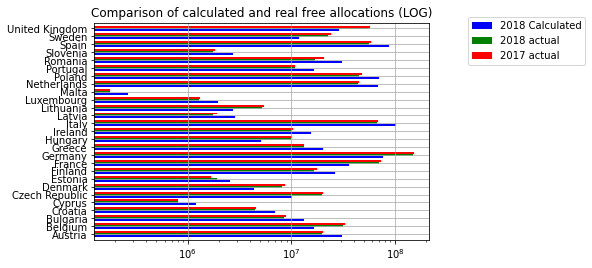

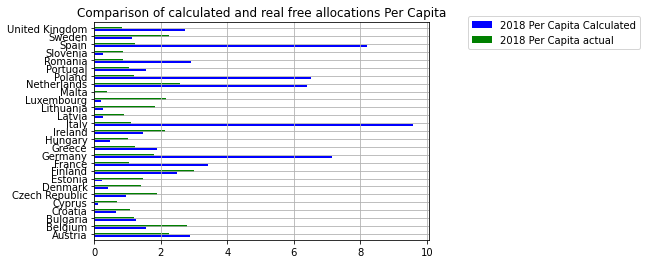

In [ ]:
f2017 = {}
f2018 = {}

f2017 = Free_allocation_2017.copy()
f2018 = Free_allocation_2018.copy()
if "Slovakia" in f2017:
    f2017.pop("Slovakia")
if "Slovakia" in f2018:
    f2018.pop("Slovakia")
per_capita_sol=[]
per_capita_actual_2018=[]
for i in range(len(solution.x)):
    per_capita_sol.append(solution.x[i]/Population[EUcountries[5]][-4])
    per_capita_actual_2018.append(f2018[EUcountries[i]]/Population[EUcountries[i]][-4])
    # per_capita_sol.append(solution.x[i])
    # per_capita_actual_2018.append(f2018[EUcountries[i]])

df = pd.DataFrame(dict(graph=EUcountries,n=solution.x, m=list(f2018.values()), d = list(f2017.values())))

ind = np.arange(len(df))
width = 0.25

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, color='blue', label='2018 Calculated')
ax.barh(ind + width, df.m, width, color='green', label='2018 actual')
ax.barh(ind + 2*width, df.d, width, color='RED', label='2017 actual')
ax.set_xscale('log')
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title('Comparison of calculated and real free allocations (LOG)')
plt.grid()
plt.show()


df = pd.DataFrame(dict(graph=EUcountries,n=per_capita_sol, m=list(per_capita_actual_2018), d = list(f2017.values())))
fig, ax = plt.subplots()
ax.barh(ind, df.n, width, color='blue', label='2018 Per Capita Calculated')
ax.barh(ind + width, df.m, width, color='green', label='2018 Per Capita actual')
# ax.set_xscale('log')
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title('Comparison of calculated and real free allocations Per Capita')
plt.grid()
plt.show()